In [3]:
import os
import pandas as pd
import numpy as np
import six
import xarray as xr
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import dates

from stompy import utils
from stompy import filters
from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver
from stompy import xr_utils
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
from stompy.spatial import field, proj_utils 
from stompy.model import data_comparison
%matplotlib notebook

In [4]:
cache_dir="cache"
os.path.exists(cache_dir) or os.makedirs(cache_dir)

True

In [89]:
six.moves.reload_module(sun_driver)
models=[
#modelA=sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_009-20170901/")
#modelA=sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_010-201706/")
#    sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_011-201706/"),
#    sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_012-201706/"),
#    sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_012-201706-tvd/"),
#    sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_013-201706/"),
    sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_015-201711/"),
    sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_016-201709/"),
]

INFO:DFlowModel:Will read cell depths, too
INFO:DFlowModel:Will read cell depths, too


In [90]:
modelA=models[-1]
for m in models:
    m.projection="EPSG:26910"
    
start=np.datetime64("2017-06-01") # or add a 1 month spinup

end  =max([m.run_stop for m in models])

for m in models:
    m.label=os.path.basename(m.run_dir)

fig_dir=os.path.join(modelA.run_dir,'figs-20190621')
os.path.exists(fig_dir) or os.makedirs(fig_dir)

True

In [33]:
def noaa_water_level(station,start,stop,**kw):
    ds=noaa_coops.coops_dataset_product(station=station,product='water_level',
                                        start_date=start,end_date=stop,
                                        cache_dir=cache_dir,clip=True)
    ds=ds.set_coords(['lon','lat'])
    da=ds.water_level.isel(station=0)
    da.attrs.update(kw)
    return da
alameda_wl=noaa_water_level(9414750,start,end,name="NOAA Alameda")
pointreyes_wl=noaa_water_level(9415020,start,end,name="NOAA Point Reyes")
sanfran_wl=noaa_water_level(9414290,start,end,name="NOAA Fort Point")
coyote_wl=noaa_water_level(9414575,start,end,name="NOAA Coyote Creek")
richmond_wl=noaa_water_level(9414863,start,end,name="NOAA Richmond")
portchicago_wl=noaa_water_level(9415144,start,end,name="NOAA Port Chicago")


INFO:noaa_coops:Cached   2017-06-01 00:00:00 -- 2017-07-01 00:00:00
INFO:noaa_coops:Cached   2017-07-01 00:00:00 -- 2017-08-01 00:00:00
INFO:noaa_coops:Cached   2017-08-01 00:00:00 -- 2017-09-01 00:00:00
INFO:noaa_coops:Cached   2017-09-01 00:00:00 -- 2017-10-01 00:00:00
INFO:noaa_coops:Cached   2017-10-01 00:00:00 -- 2017-11-01 00:00:00
INFO:noaa_coops:Cached   2017-11-01 00:00:00 -- 2017-12-01 00:00:00
INFO:noaa_coops:Cached   2017-12-01 00:00:00 -- 2018-01-01 00:00:00
INFO:noaa_coops:Cached   2017-06-01 00:00:00 -- 2017-07-01 00:00:00
INFO:noaa_coops:Cached   2017-07-01 00:00:00 -- 2017-08-01 00:00:00
INFO:noaa_coops:Cached   2017-08-01 00:00:00 -- 2017-09-01 00:00:00
INFO:noaa_coops:Cached   2017-09-01 00:00:00 -- 2017-10-01 00:00:00
INFO:noaa_coops:Cached   2017-10-01 00:00:00 -- 2017-11-01 00:00:00
INFO:noaa_coops:Cached   2017-11-01 00:00:00 -- 2017-12-01 00:00:00
INFO:noaa_coops:Cached   2017-12-01 00:00:00 -- 2018-01-01 00:00:00
INFO:noaa_coops:Cached   2017-06-01 00:00:00 -- 

<IPython.core.display.Javascript object>


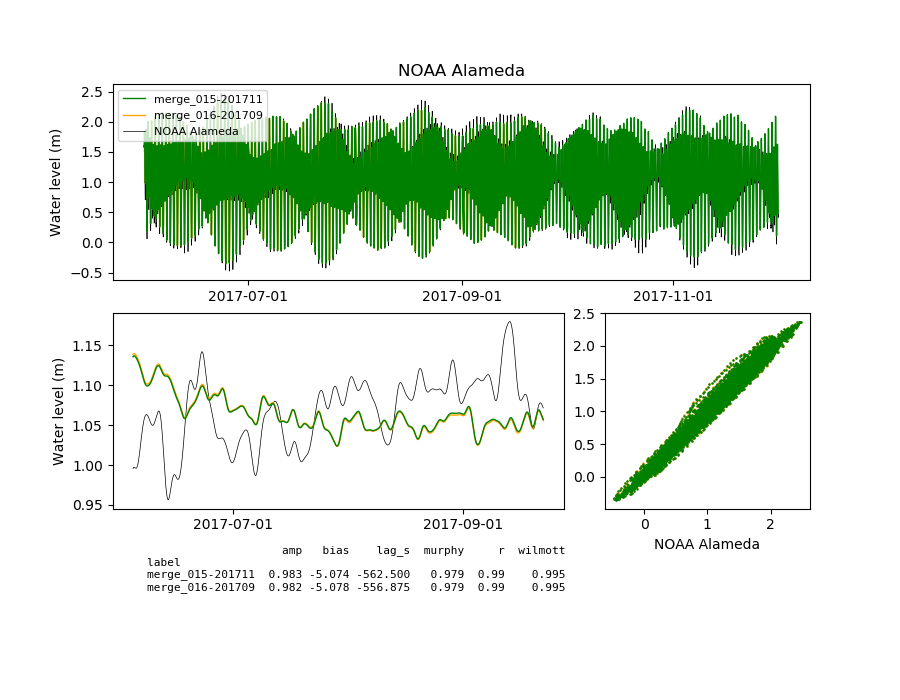

<IPython.core.display.Javascript object>


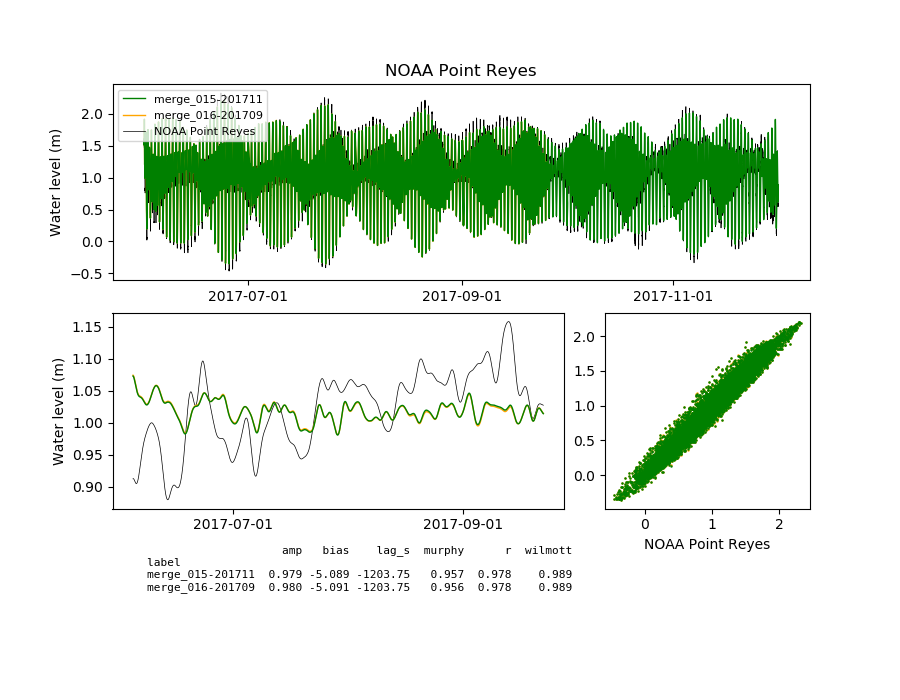

<IPython.core.display.Javascript object>


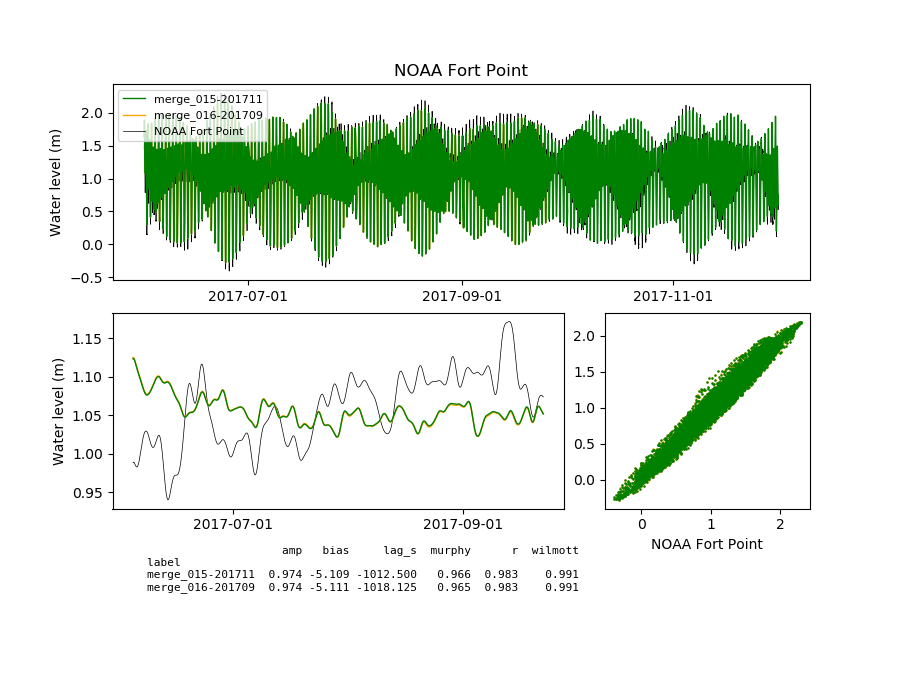

<IPython.core.display.Javascript object>


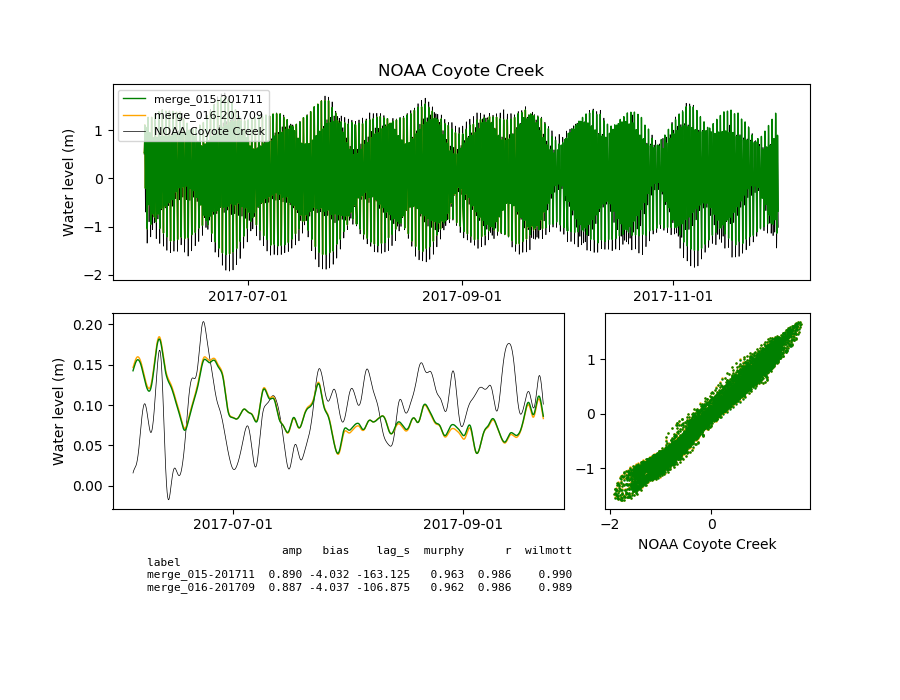

<IPython.core.display.Javascript object>


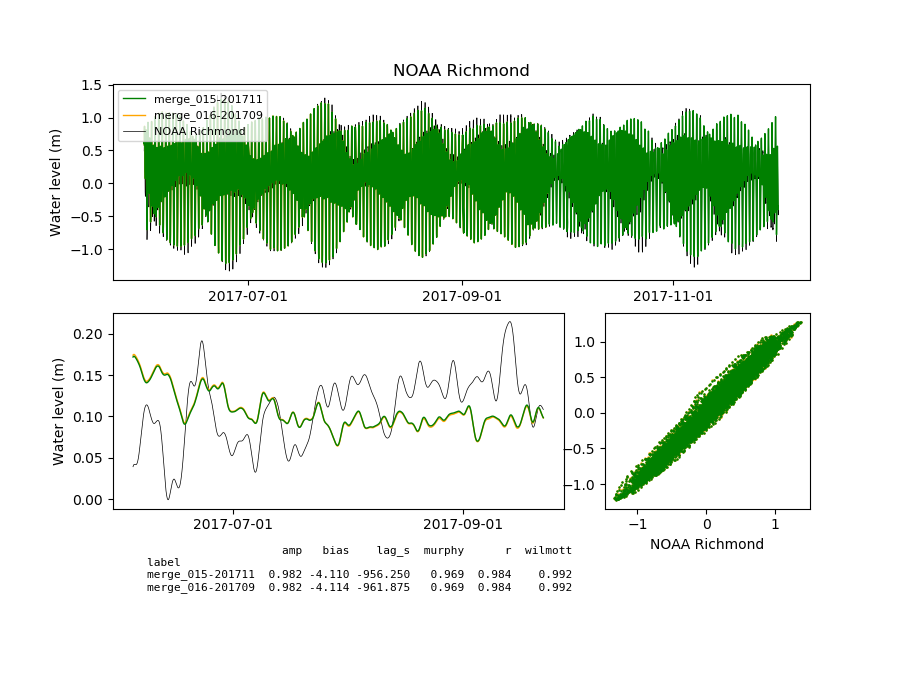

<IPython.core.display.Javascript object>


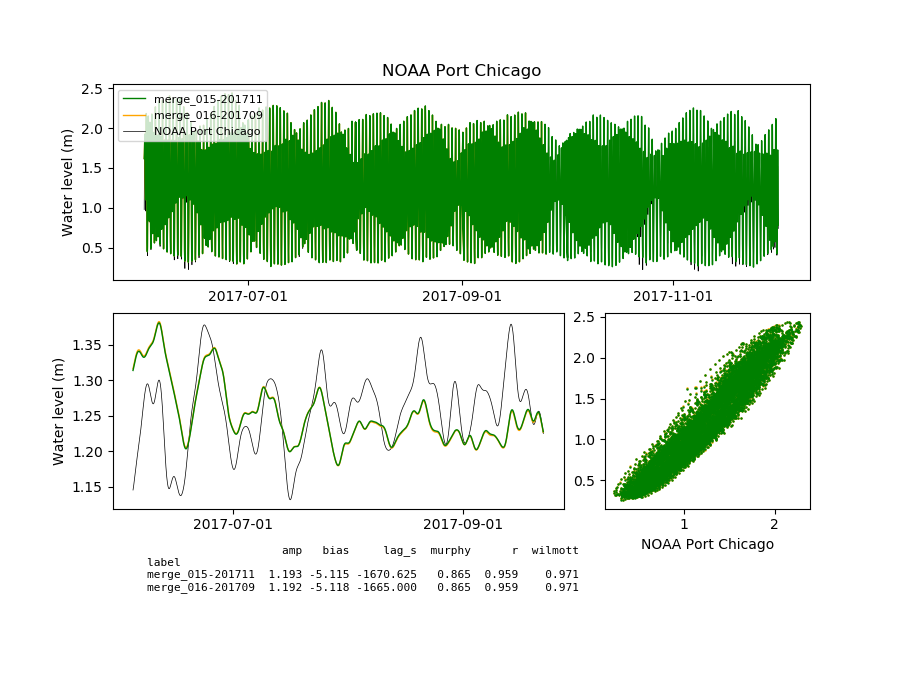

In [34]:
six.moves.reload_module(data_comparison)
model_labels=[ m.label for m in models]

for station in [alameda_wl,pointreyes_wl,sanfran_wl,coyote_wl,richmond_wl,
               portchicago_wl]:
    sources,combined=data_comparison.assemble_comparison_data(models,
                                                              [station],
                                                              model_labels=model_labels,
                                                              extract_options=dict(chain_count=start))
    fig=data_comparison.calibration_figure_3panel(sources,combined,scatter_x_source=-1,offset_source=-1,
                                                  metric_x='all',metric_ref=-1,
                                  styles=[dict(color='g',lw=1.0,zorder=1),
                                          dict(color='orange',lw=1.0,zorder=0),
                                          dict(color='k',zorder=-2,lw=0.5)])
    fig.axes[0].set_title(station.attrs['name'])
    for ax in fig.axes[:2]:
        ax.set_ylabel("Water level (m)")
    fig.savefig(os.path.join(fig_dir,"waterlevel-%s.png"%station.attrs['name'])) 


In [35]:
# Salinity vs. Polaris/Peterson
from stompy.io.local import usgs_sfbay
from stompy import xr_transect

In [36]:
six.moves.reload_module(usgs_sfbay)
# for now, show even the spinup period to see how things evolve
polaris=usgs_sfbay.usgs_sfbay_dataset(np.datetime64("2017-06-01"),
                                      end,cache_dir=cache_dir)

INFO:root:Will break that up into pieces
INFO:root:Cached 2017-06-01 00:00:00 -- 2017-07-01 00:00:00
INFO:root:Cached 2017-07-01 00:00:00 -- 2017-08-01 00:00:00
INFO:root:Cached 2017-08-01 00:00:00 -- 2017-09-01 00:00:00
INFO:root:Cached 2017-09-01 00:00:00 -- 2017-10-01 00:00:00
INFO:root:Cached 2017-10-01 00:00:00 -- 2017-11-01 00:00:00
INFO:root:Cached 2017-11-01 00:00:00 -- 2017-12-01 00:00:00
INFO:root:Cached 2017-12-01 00:00:00 -- 2018-01-01 00:00:00


In [91]:
six.moves.reload_module(xr_transect)
import matplotlib.gridspec as gridspec

lag=np.timedelta64(0*3600,'s')
def plot_cruise(models,cruise):
    ll=np.c_[ cruise.longitude, cruise.latitude ]

    print(f"Cruise period: {cruise.time.values.min()} to {cruise.time.values.max()}")
    trans=[model.extract_transect_monitor(ll=ll,time=cruise.time.values+lag,dv_from_map=True,
                                          dzmin_surface=0.25)
           for model in models ]
    if all([t is None for t in trans]):
        print("Skipping")
        return None
    
    for i in range(len(trans)):
        if trans[i] is None:
            continue
        tran=trans[i].copy()

        for fld in ['eta','z_ctr','z_top','z_bot','dv']:
            if fld in tran:
                tran[fld] = tran[fld] + 5.0
        # by default d_sample is the calculated distance, but to match the
        # Polaris/Peterson data use the exact same values, which may not start
        # at 0.
        tran.d_sample.values[:]=cruise.d_sample.values
        tran['time']=tran.sample
        trans[i]=tran
    labels=[m.label for m in models] + ['Observed']
    fig=plot_transect_comparison([(tran,'salt') for tran in trans] + 
                                 [(cruise,'Salinity')],
                                 labels=labels)
    return fig
    
def plot_transect_comparison(transects, labels=None):
    fig=plt.figure()
    gs = gridspec.GridSpec(len(transects)+1,1)

    if labels is None:
        labels=[str(i) for i in range(len(transects))]
        
    ax0=None
    for i,(tran,fld) in enumerate(transects):
        if tran is None: continue
        ax=fig.add_subplot(gs[i,0],sharex=ax0,sharey=ax0)
        if ax0 is None:
            ax0=ax
        polys=xr_transect.plot_scalar( tran, fld,cmap='jet',ax=ax, clim=[0,34])
        ax.text(0.05,0.05,labels[i],transform=ax.transAxes)
        plt.setp(ax.get_xticklabels(),visible=0)
        ax.set_ylabel('Depth (m)')

    axn=fig.add_subplot(gs[-1,0],sharex=ax0)
    axgrad=axn.twinx()
    
    for i,(tran,fld) in enumerate(transects):
        if tran is None: continue
        davg=xr_transect.depth_avg(tran,fld)
        axn.plot(tran.d_sample, davg,label=labels[i])
        fld_dz=xr_transect.d_dz(tran,fld)
        axgrad.plot(tran.d_sample,-fld_dz,ls='--',lw=0.5)
    axn.legend(loc='upper left',fontsize=8)
    axn.set_ylabel('Salinity (ppt)')
    axgrad.set_ylabel('-ds/dz')
    axn.set_xlabel('Distance (m)')
    
    ax0.axis(ymin=-50)
    for tran,_ in transects: # use first existing transect to get date
        if tran is not None: break
    if 'time' in tran:
        t=tran['time'].min()
    elif 'sample' in tran:
        t=tran['sample'].min()
    ax0.set_title(utils.to_datetime(t).strftime("%Y-%m-%d"))
    return fig

def load_cruise(cruise_i):
    cruise=polaris.isel(cruise=cruise_i)

    cruise=cruise.sortby('Distance from 36').sortby('depth')
    cruise['d_sample']=1000*cruise['Distance from 36']
    cruise['z_ctr']=-cruise['depth']
    cruise=cruise.rename(depth='layer')
    stn_sel=np.isfinite(cruise.Salinity.max(dim='layer'))
    cruise=cruise.isel(station=stn_sel)
    return cruise

Cruise period: 2017-06-06T17:25:00.000000000 to 2017-06-06T20:43:00.000000000
[sample 0,k 5] too thin
[sample 1,k 5] too thin
[sample 2,k 5] too thin
[sample 3,k 5] too thin
[sample 4,k 5] too thin
[sample 5,k 5] too thin
[sample 6,k 5] too thin
[sample 7,k 5] too thin
[sample 8,k 5] too thin
[sample 9,k 5] too thin
[sample 10,k 5] too thin
[sample 11,k 5] too thin
[sample 12,k 5] too thin
[sample 13,k 5] too thin
[sample 14,k 5] too thin
[sample 15,k 5] too thin
[sample 16,k 5] too thin
[sample 0,k 5] too thin
[sample 1,k 5] too thin
[sample 2,k 5] too thin
[sample 3,k 5] too thin
[sample 4,k 5] too thin
[sample 5,k 5] too thin
[sample 6,k 5] too thin
[sample 7,k 5] too thin
[sample 8,k 5] too thin
[sample 9,k 5] too thin
[sample 10,k 5] too thin
[sample 11,k 5] too thin
[sample 12,k 5] too thin
[sample 13,k 5] too thin
[sample 14,k 5] too thin
[sample 15,k 5] too thin
[sample 16,k 5] too thin


<IPython.core.display.Javascript object>


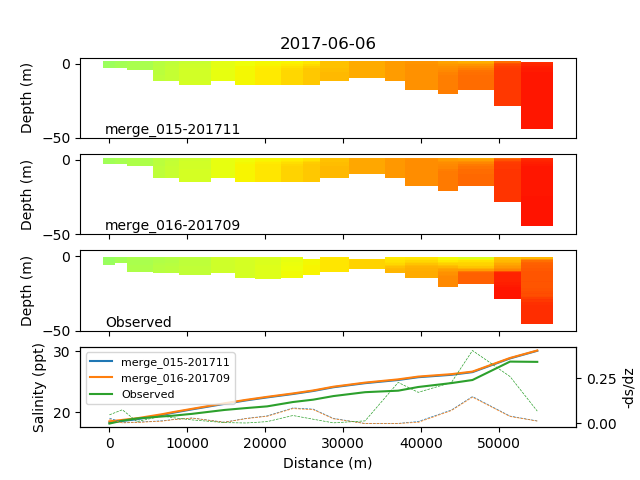

Cruise period: 2017-06-22T13:20:00.000000000 to 2017-06-22T22:17:00.000000000
[sample 4,k 5] too thin
[sample 5,k 5] too thin
[sample 6,k 5] too thin
[sample 7,k 5] too thin
[sample 8,k 5] too thin
[sample 9,k 5] too thin
[sample 10,k 5] too thin
[sample 11,k 5] too thin
[sample 14,k 5] too thin
[sample 15,k 5] too thin
[sample 16,k 5] too thin
[sample 17,k 5] too thin
[sample 18,k 5] too thin
[sample 19,k 5] too thin
[sample 25,k 6] too thin
[sample 32,k 6] too thin
[sample 33,k 6] too thin
[sample 4,k 5] too thin
[sample 5,k 5] too thin
[sample 6,k 5] too thin
[sample 7,k 5] too thin
[sample 8,k 5] too thin
[sample 9,k 5] too thin
[sample 10,k 5] too thin
[sample 11,k 5] too thin
[sample 14,k 5] too thin
[sample 15,k 5] too thin
[sample 16,k 5] too thin
[sample 17,k 5] too thin
[sample 18,k 5] too thin
[sample 19,k 5] too thin
[sample 25,k 6] too thin
[sample 32,k 6] too thin
[sample 33,k 6] too thin


<IPython.core.display.Javascript object>


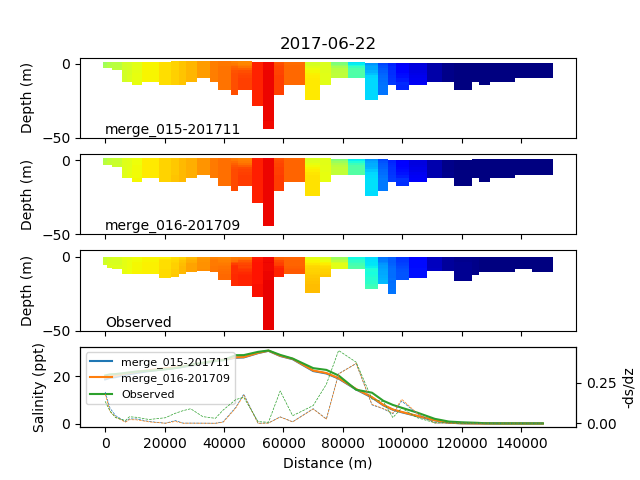

Cruise period: 2017-07-25T14:12:00.000000000 to 2017-07-25T22:26:00.000000000
[sample 4,k 7] too thin
[sample 5,k 7] too thin
[sample 6,k 7] too thin
[sample 7,k 7] too thin
[sample 8,k 7] too thin
[sample 9,k 7] too thin
[sample 10,k 7] too thin
[sample 20,k 6] too thin
[sample 21,k 6] too thin
[sample 22,k 6] too thin
[sample 23,k 6] too thin
[sample 24,k 6] too thin
[sample 33,k 5] too thin
[sample 34,k 5] too thin
[sample 4,k 7] too thin
[sample 5,k 7] too thin
[sample 6,k 7] too thin
[sample 7,k 7] too thin
[sample 8,k 7] too thin
[sample 9,k 7] too thin
[sample 10,k 7] too thin
[sample 20,k 6] too thin
[sample 21,k 6] too thin
[sample 22,k 6] too thin
[sample 23,k 6] too thin
[sample 24,k 6] too thin
[sample 33,k 5] too thin
[sample 34,k 5] too thin


<IPython.core.display.Javascript object>


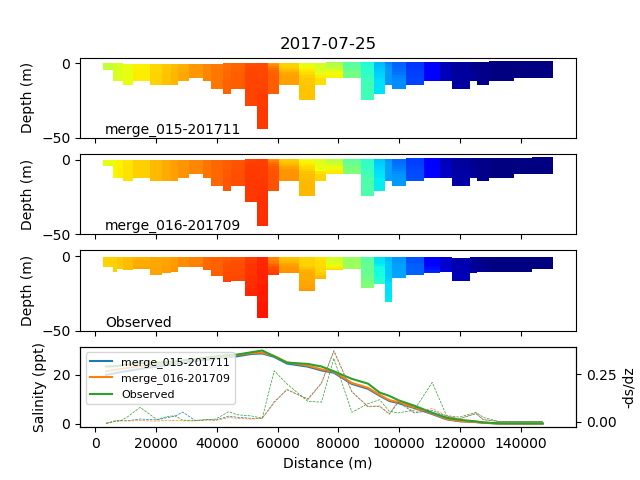

Cruise period: 2017-07-31T14:57:00.000000000 to 2017-07-31T18:09:00.000000000
[sample 0,k 5] too thin
[sample 1,k 5] too thin
[sample 2,k 5] too thin
[sample 17,k 6] too thin
[sample 18,k 6] too thin
[sample 0,k 5] too thin
[sample 1,k 5] too thin
[sample 2,k 5] too thin
[sample 17,k 6] too thin
[sample 18,k 6] too thin


<IPython.core.display.Javascript object>


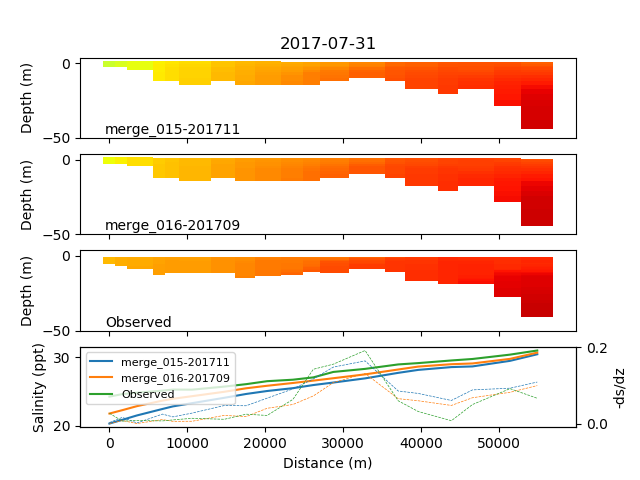

Cruise period: 2017-08-22T14:11:00.000000000 to 2017-08-22T22:30:00.000000000
[sample 1,k 7] too thin
[sample 2,k 7] too thin
[sample 3,k 7] too thin
[sample 4,k 7] too thin
[sample 5,k 7] too thin
[sample 12,k 6] too thin
[sample 13,k 6] too thin
[sample 27,k 5] too thin
[sample 28,k 5] too thin
[sample 29,k 5] too thin
[sample 30,k 5] too thin
[sample 31,k 5] too thin
[sample 32,k 5] too thin
[sample 1,k 7] too thin
[sample 2,k 7] too thin
[sample 3,k 7] too thin
[sample 4,k 7] too thin
[sample 5,k 7] too thin
[sample 12,k 6] too thin
[sample 13,k 6] too thin
[sample 27,k 5] too thin
[sample 28,k 5] too thin
[sample 29,k 5] too thin
[sample 30,k 5] too thin
[sample 31,k 5] too thin
[sample 32,k 5] too thin


<IPython.core.display.Javascript object>


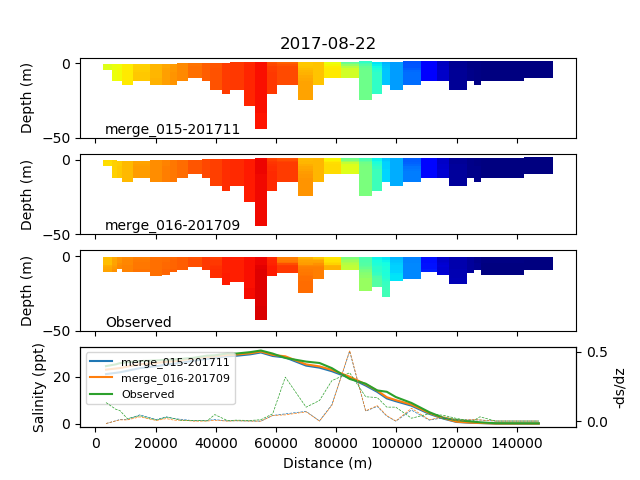

Cruise period: 2017-08-30T15:04:00.000000000 to 2017-08-30T18:19:00.000000000
[sample 0,k 5] too thin
[sample 1,k 5] too thin
[sample 2,k 5] too thin
[sample 3,k 5] too thin
[sample 4,k 5] too thin
[sample 5,k 5] too thin
[sample 1,k 5] too thin
[sample 2,k 5] too thin
[sample 3,k 5] too thin
[sample 4,k 5] too thin


<IPython.core.display.Javascript object>


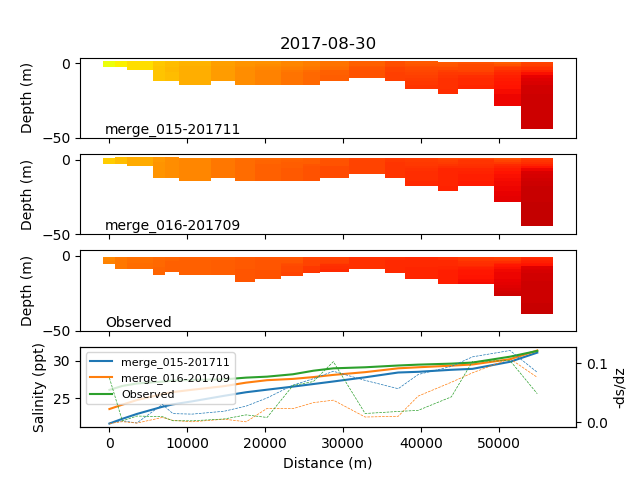

Cruise period: 2017-09-19T14:03:00.000000000 to 2017-09-19T21:50:00.000000000
[sample 0,k 7] too thin
[sample 1,k 7] too thin
[sample 2,k 7] too thin
[sample 8,k 6] too thin
[sample 9,k 6] too thin
[sample 10,k 6] too thin
[sample 16,k 5] too thin
[sample 17,k 5] too thin
[sample 18,k 5] too thin
[sample 19,k 5] too thin
[sample 20,k 5] too thin
[sample 21,k 5] too thin
[sample 22,k 5] too thin
[sample 23,k 5] too thin
[sample 24,k 5] too thin
[sample 25,k 5] too thin
[sample 26,k 5] too thin
[sample 0,k 7] too thin
[sample 1,k 7] too thin
[sample 2,k 7] too thin
[sample 3,k 7] too thin
[sample 9,k 6] too thin
[sample 10,k 6] too thin
[sample 16,k 5] too thin
[sample 17,k 5] too thin
[sample 18,k 5] too thin
[sample 19,k 5] too thin
[sample 20,k 5] too thin
[sample 21,k 5] too thin
[sample 22,k 5] too thin
[sample 23,k 5] too thin
[sample 24,k 5] too thin
[sample 25,k 5] too thin
[sample 26,k 5] too thin


<IPython.core.display.Javascript object>


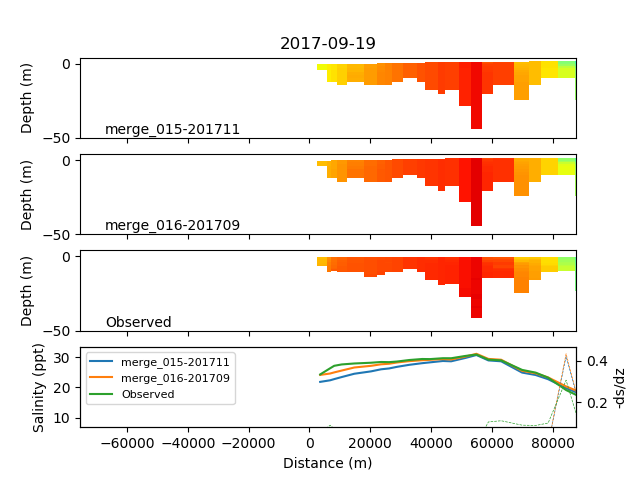

Cruise period: 2017-09-28T15:03:00.000000000 to 2017-09-28T18:27:00.000000000
[sample 0,k 5] too thin
[sample 1,k 5] too thin
[sample 2,k 5] too thin
[sample 3,k 5] too thin
[sample 4,k 5] too thin
[sample 5,k 5] too thin
[sample 6,k 5] too thin
[sample 0,k 5] too thin
[sample 1,k 5] too thin
[sample 2,k 5] too thin
[sample 3,k 5] too thin
[sample 4,k 5] too thin
[sample 5,k 5] too thin
[sample 6,k 5] too thin


<IPython.core.display.Javascript object>


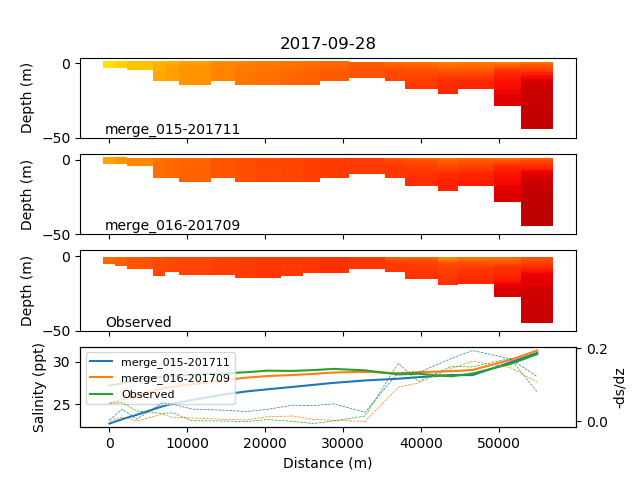

Cruise period: 2017-10-18T14:10:00.000000000 to 2017-10-18T22:02:00.000000000
[sample 5,k 6] too thin
[sample 6,k 6] too thin
[sample 12,k 5] too thin
[sample 13,k 5] too thin
[sample 14,k 5] too thin


INFO:root:Requested time 2017-10-18T14:10:00.000000000 is outside the range of the model output


<IPython.core.display.Javascript object>


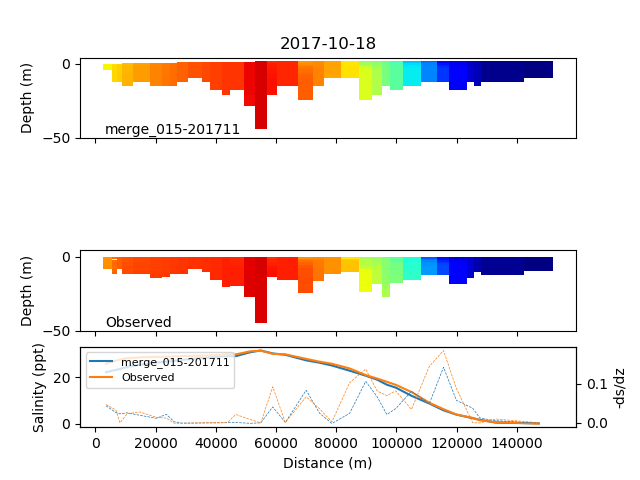

Cruise period: 2017-10-27T15:05:00.000000000 to 2017-10-27T18:20:00.000000000


INFO:root:Requested time 2017-10-27T15:05:00.000000000 is outside the range of the model output


[sample 0,k 5] too thin
[sample 1,k 5] too thin
[sample 2,k 5] too thin
[sample 3,k 5] too thin
[sample 4,k 5] too thin
[sample 5,k 5] too thin
[sample 6,k 5] too thin


<IPython.core.display.Javascript object>


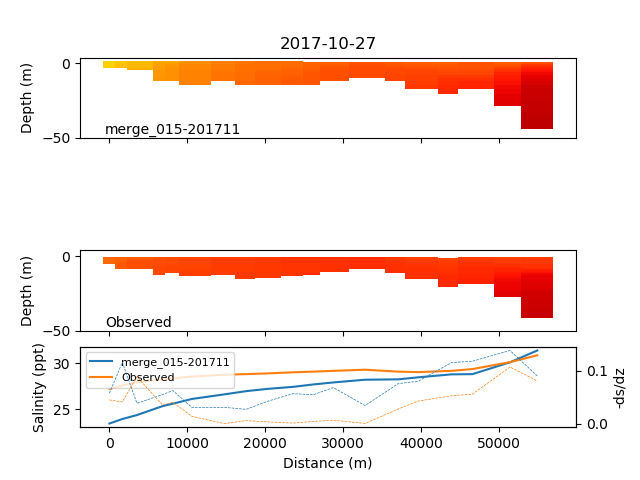

Cruise period: 2017-11-14T15:10:00.000000000 to 2017-11-14T23:58:00.000000000
[sample 0,k 5] too thin
[sample 1,k 5] too thin
[sample 16,k 5] too thin
[sample 17,k 5] too thin
[sample 35,k 6] too thin


INFO:root:Requested time 2017-11-14T15:10:00.000000000 is outside the range of the model output


<IPython.core.display.Javascript object>


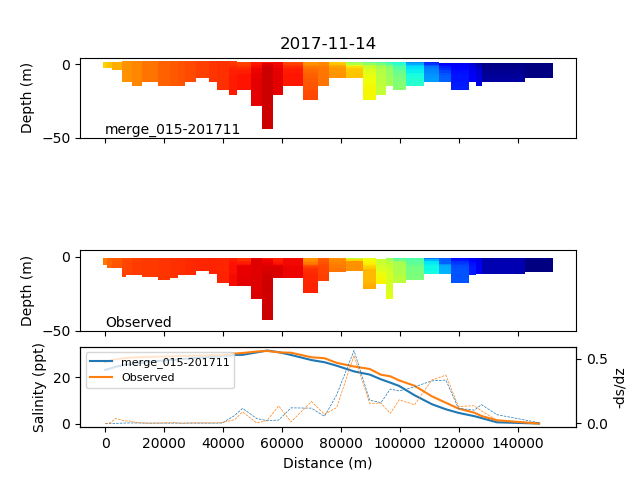

INFO:root:Requested time 2017-12-06T15:11:00.000000000 is outside the range of the model output


Cruise period: 2017-12-06T15:11:00.000000000 to 2017-12-06T23:21:00.000000000


INFO:root:Requested time 2017-12-06T15:11:00.000000000 is outside the range of the model output


Skipping


In [92]:

for cruise_i in range(polaris.dims['cruise']):
    cruise=load_cruise(cruise_i)
    ll=np.c_[ cruise.longitude, cruise.latitude ]
    
    fig=plot_cruise(models,cruise)
    if fig is None: continue
    date_str=utils.to_datetime(cruise.cruise.values).strftime("%Y-%m-%d")
    fig.savefig(os.path.join(fig_dir,"polaris-%s.png"%date_str))

    

In [49]:
# debugging the thin surface layers
cruise=load_cruise(10)

ll=np.c_[ cruise.longitude, cruise.latitude ]

In [79]:
six.moves.reload_module(sun_driver)
model=sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_015-201711/")
model.projection="EPSG:26910"
tran=model.extract_transect_monitor(ll=ll,time=cruise.time.values,dv_from_map=True)
model.adjust_transect_for_dzmin_surface(tran)

INFO:DFlowModel:Will read cell depths, too


[sample 21,k 5] too thin
[sample 22,k 5] too thin
[sample 23,k 5] too thin
[sample 24,k 5] too thin
[sample 25,k 5] too thin
[sample 26,k 5] too thin


In [57]:
z_dz=xr_transect.get_z_dz(tran)

In [76]:
def apply_dzmin_surface(tran,update_vars=['salt','temp'],dzmin_surf=0.25):
    z_dz=xr_transect.get_z_dz(tran) 
    for samp_i in range(tran.dims['sample']):
        eta=tran.eta.isel(sample=samp_i)
        k_update=[]
        for k in range(tran.dims['layer']):
            if z_dz[samp_i,k]==0.0: 
                continue # truly dry
            elif tran.eta[samp_i] - tran.z_bot[samp_i,k] < dzmin_surf:
                print(f"[sample {samp_i},k {k}] too thin")
                k_update.append(k)
            else:
                # valid layer
                for ku in k_update:
                    for v in update_vars:
                        tran[v].values[samp_i,ku] = tran[v].values[samp_i,k]
                break


[sample 0,k 5] too thin
[sample 1,k 5] too thin
[sample 16,k 5] too thin
[sample 17,k 5] too thin
[sample 35,k 6] too thin


In [81]:
tran.salt.isel(sample=21)

<xarray.DataArray 'salt' (layer: 60)>
array([ 0.      ,  0.      ,  0.      ,  0.      ,  0.      , 17.889856,
       17.889856, 18.964444, 19.135875,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan])
Coordinates:
    sample   datetime64[ns] 2017-11-14T19:45:00
Dimensions without coordinates: layer